# Description

This notebook evaluates how a spectral clustering method performs as a consensus function. It takes the coassociation matrix, applies several `delta` values to transform it, and computes different clustering quality measures to assess performance. An optimal `delta` value is chosen, and will be used to perform the full analysis later.

This notebook loads the `z_score_std` data version to compute two of the clustering quality measures (Calinski-Harabasz and Davies-Bouldin). The Silhouette score is computed on the ensemble distance matrix (coassociation matrix), so it is not affected by the data loaded. There are other two notebooks that perform exactly the same steps here but using the `pca` and `umap` data versions to compute the quality measures.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 100000

In [6]:
# output dir for this notebook
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering')

# Load data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


In [13]:
traits = data.index.tolist()

In [14]:
len(traits)

3752

# Load coassociation matrix (ensemble)

In [15]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "ensemble_coassoc_matrix.npy").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering/ensemble_coassoc_matrix.npy')

In [16]:
coassoc_matrix = np.load(input_file)

In [17]:
coassoc_matrix = pd.DataFrame(
    data=coassoc_matrix,
    index=traits,
    columns=traits,
)

In [18]:
coassoc_matrix.shape

(3752, 3752)

In [19]:
coassoc_matrix.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
100001_raw-Food_weight,0.000000,0.314971,0.328000,0.367543,0.341257,0.369347,0.361951,0.354124,0.330439,0.364853,...,0.461101,0.443161,0.440617,0.442608,0.486303,0.359294,0.430441,0.479511,0.411417,0.644333
100002_raw-Energy,0.314971,0.000000,0.041534,0.076677,0.049064,0.078977,0.092762,0.068478,0.066438,0.629198,...,0.678784,0.683862,0.661792,0.686445,0.685388,0.616157,0.670675,0.678686,0.648605,0.674960
100003_raw-Protein,0.328000,0.041534,0.000000,0.102465,0.058421,0.104771,0.117041,0.090390,0.074201,0.639022,...,0.678326,0.688199,0.673446,0.686216,0.670548,0.614560,0.664662,0.664080,0.642204,0.677014
100004_raw-Fat,0.367543,0.076677,0.102465,0.000000,0.052031,0.005250,0.049015,0.029674,0.107763,0.603838,...,0.652949,0.645971,0.627514,0.654724,0.648858,0.667503,0.711378,0.652214,0.692273,0.646656
100005_raw-Carbohydrate,0.341257,0.049064,0.058421,0.052031,0.000000,0.055010,0.070316,0.036293,0.097489,0.612063,...,0.661866,0.668112,0.642139,0.667047,0.665525,0.646965,0.701203,0.659288,0.679241,0.653047


In [20]:
dist_matrix = coassoc_matrix

# Clustering

In [21]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

from clustering.utils import compute_performance

## `delta` parameter (gaussian kernel)

Here I perform some quick tests using different `delta` values for the width of the Gaussian kernel applied to the ensemble distance matrix in (`dist_matrix`).

### `delta=1.0`

In [22]:
delta = 1.0

In [23]:
with warnings.catch_warnings():
    # make sure all warnings are shown to debug the fitting process
    warnings.filterwarnings("always")

    # Transform the distance matrix (from the ensemble) into a similarity matrix
    # by applying a Gaussian kernel (the suggestion is taken from the Notes in
    # https://scikit-learn.org/0.23/modules/generated/sklearn.cluster.SpectralClustering.html
    sim_matrix = np.exp(-(dist_matrix**2) / (2.0 * delta**2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [24]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3130
1     622
dtype: int64

In [25]:
# show some clustering performance measures to assess the quality of the partition
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.231'

'Calinski-Harabasz (higher is better): 41.703'

'Davies-Bouldin (lower is better): 7.200'

{'si': 0.23116511015019045, 'ch': 41.70289463157456, 'db': 7.200269868038781}

For `delta=1.0`, the algorithm works fine with this data version.

### `delta>1.0`

In [26]:
delta = 5.0

In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix**2) / (2.0 * delta**2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [28]:
# show number of clusters and their size
pd.Series(part).value_counts()

1    3125
0     627
dtype: int64

In [29]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.230'

'Calinski-Harabasz (higher is better): 41.608'

'Davies-Bouldin (lower is better): 7.229'

{'si': 0.23024386632454283, 'ch': 41.607744206625, 'db': 7.229253286612492}

For `delta` values larger than `1.0`, all quality measures go slightly down.

### `delta<1.0`

In [30]:
delta = 0.20

In [31]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix**2) / (2.0 * delta**2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [32]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3740
1      12
dtype: int64

In [33]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.414'

'Calinski-Harabasz (higher is better): 16.543'

'Davies-Bouldin (lower is better): 1.327'

{'si': 0.4136140722075767, 'ch': 16.54299382474996, 'db': 1.32685451095973}

For `delta` values smaller than `1.0`, most quality measures improve.

### `delta<<<1.0`

In [34]:
delta = 0.10

In [35]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    sim_matrix = np.exp(-(dist_matrix**2) / (2.0 * delta**2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-4,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [36]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3743
1       9
dtype: int64

In [37]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.159'

'Calinski-Harabasz (higher is better): 4.484'

'Davies-Bouldin (lower is better): 2.418'

{'si': 0.1585862895845919, 'ch': 4.484084377205804, 'db': 2.4177671082962724}

For `delta` values around `0.10` the algorithm does not converge, and I need to force convergence with `eigen_tol=1e-4`.

Quality measures in general go down.

## More exhaustive test

Here I run some test across several `k` and `delta` values; then I check how results perform with different clustering quality measures.

In [38]:
from clustering.methods import DeltaSpectralClustering

In [39]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [
    2,
    4,
    6,
    8,
    10,
    12,
    14,
    16,
    18,
    20,
    25,
    30,
    35,
    40,
    50,
    60,
]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["DELTAS"] = [
    5.00,
    2.00,
    1.00,
    0.90,
    0.75,
    0.50,
    0.30,
    0.25,
    0.20,
]

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 50, 60],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'DELTAS': [5.0, 2.0, 1.0, 0.9, 0.75, 0.5, 0.3, 0.25, 0.2]}

In [40]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for delta_value in CLUSTERING_OPTIONS["DELTAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = DeltaSpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                delta=delta_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [41]:
display(len(CLUSTERERS))

720

In [42]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DeltaSpectralClustering #0', DeltaSpectralClustering(delta=5.0))

('DeltaSpectralClustering #1', DeltaSpectralClustering(delta=5.0))

In [43]:
clustering_method_name = method_name
display(clustering_method_name)

'DeltaSpectralClustering'

### Generate ensemble

In [44]:
import tempfile
from clustering.ensembles.utils import generate_ensemble

In [45]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    "pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [46]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(CLUSTERING_OPTIONS, prefix="ensemble-", suffix=".pkl"),
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/DeltaSpectralClustering/ensemble-DELTAS_50_20_10_09_075_05_03_025_02-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_12_14_16_18_20_25_30_35_40_50_60-N_REPS_PER_K_5.pkl')

In [47]:
if ensemble_file.exists():
    display("Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        dist_matrix,
        CLUSTERERS,
        attributes=["n_clusters", "delta"],
    )

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 1/720 [00:01<13:14,  1.11s/it]

  0%|          | 2/720 [00:02<13:11,  1.10s/it]

  0%|          | 3/720 [00:03<13:11,  1.10s/it]

  1%|          | 4/720 [00:04<13:08,  1.10s/it]

  1%|          | 5/720 [00:05<13:07,  1.10s/it]

  1%|          | 6/720 [00:06<13:05,  1.10s/it]

  1%|          | 7/720 [00:07<13:04,  1.10s/it]

  1%|          | 8/720 [00:08<13:04,  1.10s/it]

  1%|▏         | 9/720 [00:09<13:03,  1.10s/it]

  1%|▏         | 10/720 [00:11<13:02,  1.10s/it]

  2%|▏         | 11/720 [00:12<13:00,  1.10s/it]

  2%|▏         | 12/720 [00:13<12:58,  1.10s/it]

  2%|▏         | 13/720 [00:14<12:56,  1.10s/it]

  2%|▏         | 14/720 [00:15<12:54,  1.10s/it]

  2%|▏         | 15/720 [00:16<12:54,  1.10s/it]

  2%|▏         | 16/720 [00:17<12:53,  1.10s/it]

  2%|▏         | 17/720 [00:18<12:53,  1.10s/it]

  2%|▎         | 18/720 [00:19<12:51,  1.10s/it]

  3%|▎         | 19/720 [00:20<12:52,  1.10s/it]

  3%|▎         | 20/720 [00:22<12:50,  1.10s/it]

  3%|▎         | 21/720 [00:23<12:47,  1.10s/it]

  3%|▎         | 22/720 [00:24<12:45,  1.10s/it]

  3%|▎         | 23/720 [00:25<12:43,  1.10s/it]

  3%|▎         | 24/720 [00:26<12:43,  1.10s/it]

  3%|▎         | 25/720 [00:27<12:42,  1.10s/it]

  4%|▎         | 26/720 [00:28<12:40,  1.10s/it]

  4%|▍         | 27/720 [00:29<12:59,  1.13s/it]

  4%|▍         | 28/720 [00:30<13:15,  1.15s/it]

  4%|▍         | 29/720 [00:32<13:26,  1.17s/it]

  4%|▍         | 30/720 [00:33<13:31,  1.18s/it]

  4%|▍         | 31/720 [00:34<13:33,  1.18s/it]

  4%|▍         | 32/720 [00:35<13:35,  1.18s/it]

  5%|▍         | 33/720 [00:36<13:36,  1.19s/it]

  5%|▍         | 34/720 [00:38<13:37,  1.19s/it]

  5%|▍         | 35/720 [00:39<13:37,  1.19s/it]

  5%|▌         | 36/720 [00:40<13:35,  1.19s/it]

  5%|▌         | 37/720 [00:41<13:35,  1.19s/it]

  5%|▌         | 38/720 [00:42<13:37,  1.20s/it]

  5%|▌         | 39/720 [00:44<13:35,  1.20s/it]

  6%|▌         | 40/720 [00:45<13:34,  1.20s/it]

  6%|▌         | 41/720 [00:46<14:15,  1.26s/it]

  6%|▌         | 42/720 [00:48<14:43,  1.30s/it]

  6%|▌         | 43/720 [00:49<15:26,  1.37s/it]

  6%|▌         | 44/720 [00:51<15:35,  1.38s/it]

  6%|▋         | 45/720 [00:52<16:00,  1.42s/it]

  6%|▋         | 46/720 [00:53<15:14,  1.36s/it]

  7%|▋         | 47/720 [00:55<16:12,  1.44s/it]

  7%|▋         | 48/720 [00:56<15:22,  1.37s/it]

  7%|▋         | 49/720 [00:57<15:04,  1.35s/it]

  7%|▋         | 50/720 [00:59<14:35,  1.31s/it]

  7%|▋         | 51/720 [01:00<14:14,  1.28s/it]

  7%|▋         | 52/720 [01:01<13:59,  1.26s/it]

  7%|▋         | 53/720 [01:02<13:47,  1.24s/it]

  8%|▊         | 54/720 [01:04<15:05,  1.36s/it]

  8%|▊         | 55/720 [01:05<15:08,  1.37s/it]

  8%|▊         | 56/720 [01:07<15:24,  1.39s/it]

  8%|▊         | 57/720 [01:08<15:12,  1.38s/it]

  8%|▊         | 58/720 [01:09<14:52,  1.35s/it]

  8%|▊         | 59/720 [01:11<15:57,  1.45s/it]

  8%|▊         | 60/720 [01:13<15:54,  1.45s/it]

  8%|▊         | 61/720 [01:14<15:22,  1.40s/it]

  9%|▊         | 62/720 [01:15<14:57,  1.36s/it]

  9%|▉         | 63/720 [01:17<15:12,  1.39s/it]

  9%|▉         | 64/720 [01:18<15:09,  1.39s/it]

  9%|▉         | 65/720 [01:19<15:40,  1.44s/it]

  9%|▉         | 66/720 [01:21<15:08,  1.39s/it]

  9%|▉         | 67/720 [01:22<15:19,  1.41s/it]

  9%|▉         | 68/720 [01:24<16:04,  1.48s/it]

 10%|▉         | 69/720 [01:25<15:39,  1.44s/it]

 10%|▉         | 70/720 [01:26<15:04,  1.39s/it]

 10%|▉         | 71/720 [01:28<15:22,  1.42s/it]

 10%|█         | 72/720 [01:30<15:57,  1.48s/it]

 10%|█         | 73/720 [01:31<15:01,  1.39s/it]

 10%|█         | 74/720 [01:32<15:33,  1.45s/it]

 10%|█         | 75/720 [01:34<16:27,  1.53s/it]

 11%|█         | 76/720 [01:35<15:22,  1.43s/it]

 11%|█         | 77/720 [01:37<15:31,  1.45s/it]

 11%|█         | 78/720 [01:38<15:09,  1.42s/it]

 11%|█         | 79/720 [01:40<15:08,  1.42s/it]

 11%|█         | 80/720 [01:41<15:04,  1.41s/it]

 11%|█▏        | 81/720 [01:42<14:43,  1.38s/it]

 11%|█▏        | 82/720 [01:44<15:11,  1.43s/it]

 12%|█▏        | 83/720 [01:45<15:13,  1.43s/it]

 12%|█▏        | 84/720 [01:47<15:34,  1.47s/it]

 12%|█▏        | 85/720 [01:48<14:57,  1.41s/it]

 12%|█▏        | 86/720 [01:49<15:03,  1.42s/it]

 12%|█▏        | 87/720 [01:51<15:40,  1.49s/it]

 12%|█▏        | 88/720 [01:53<15:46,  1.50s/it]

 12%|█▏        | 89/720 [01:54<15:38,  1.49s/it]

 12%|█▎        | 90/720 [01:56<15:38,  1.49s/it]

 13%|█▎        | 91/720 [01:57<15:26,  1.47s/it]

 13%|█▎        | 92/720 [01:58<15:14,  1.46s/it]

 13%|█▎        | 93/720 [02:00<15:43,  1.51s/it]

 13%|█▎        | 94/720 [02:01<14:57,  1.43s/it]

 13%|█▎        | 95/720 [02:03<16:00,  1.54s/it]

 13%|█▎        | 96/720 [02:05<16:35,  1.60s/it]

 13%|█▎        | 97/720 [02:06<15:46,  1.52s/it]

 14%|█▎        | 98/720 [02:07<15:00,  1.45s/it]

 14%|█▍        | 99/720 [02:09<15:17,  1.48s/it]

 14%|█▍        | 100/720 [02:11<16:16,  1.57s/it]

 14%|█▍        | 101/720 [02:12<15:35,  1.51s/it]

 14%|█▍        | 102/720 [02:14<16:14,  1.58s/it]

 14%|█▍        | 103/720 [02:15<15:45,  1.53s/it]

 14%|█▍        | 104/720 [02:17<14:57,  1.46s/it]

 15%|█▍        | 105/720 [02:18<14:38,  1.43s/it]

 15%|█▍        | 106/720 [02:19<14:23,  1.41s/it]

 15%|█▍        | 107/720 [02:21<14:19,  1.40s/it]

 15%|█▌        | 108/720 [02:22<13:54,  1.36s/it]

 15%|█▌        | 109/720 [02:24<15:21,  1.51s/it]

 15%|█▌        | 110/720 [02:25<14:37,  1.44s/it]

 15%|█▌        | 111/720 [02:27<14:47,  1.46s/it]

 16%|█▌        | 112/720 [02:28<14:43,  1.45s/it]

 16%|█▌        | 113/720 [02:30<15:11,  1.50s/it]

 16%|█▌        | 114/720 [02:31<14:47,  1.47s/it]

 16%|█▌        | 115/720 [02:33<15:58,  1.58s/it]

 16%|█▌        | 116/720 [02:34<15:31,  1.54s/it]

 16%|█▋        | 117/720 [02:36<14:40,  1.46s/it]

 16%|█▋        | 118/720 [02:37<15:19,  1.53s/it]

 17%|█▋        | 119/720 [02:39<14:29,  1.45s/it]

 17%|█▋        | 120/720 [02:40<13:57,  1.40s/it]

 17%|█▋        | 121/720 [02:41<14:13,  1.42s/it]

 17%|█▋        | 122/720 [02:43<14:33,  1.46s/it]

 17%|█▋        | 123/720 [02:44<14:38,  1.47s/it]

 17%|█▋        | 124/720 [02:46<15:05,  1.52s/it]

 17%|█▋        | 125/720 [02:48<15:32,  1.57s/it]

 18%|█▊        | 126/720 [02:49<15:12,  1.54s/it]

 18%|█▊        | 127/720 [02:51<15:47,  1.60s/it]

 18%|█▊        | 128/720 [02:52<14:59,  1.52s/it]

 18%|█▊        | 129/720 [02:54<14:57,  1.52s/it]

 18%|█▊        | 130/720 [02:55<14:50,  1.51s/it]

 18%|█▊        | 131/720 [02:57<14:19,  1.46s/it]

 18%|█▊        | 132/720 [02:58<13:46,  1.40s/it]

 18%|█▊        | 133/720 [02:59<13:50,  1.42s/it]

 19%|█▊        | 134/720 [03:01<14:03,  1.44s/it]

 19%|█▉        | 135/720 [03:02<14:04,  1.44s/it]

 19%|█▉        | 136/720 [03:04<14:25,  1.48s/it]

 19%|█▉        | 137/720 [03:05<13:53,  1.43s/it]

 19%|█▉        | 138/720 [03:07<13:52,  1.43s/it]

 19%|█▉        | 139/720 [03:08<13:33,  1.40s/it]

 19%|█▉        | 140/720 [03:09<13:58,  1.45s/it]

 20%|█▉        | 141/720 [03:11<14:53,  1.54s/it]

 20%|█▉        | 142/720 [03:13<16:10,  1.68s/it]

 20%|█▉        | 143/720 [03:15<15:08,  1.57s/it]

 20%|██        | 144/720 [03:16<14:24,  1.50s/it]

 20%|██        | 145/720 [03:17<14:07,  1.47s/it]

 20%|██        | 146/720 [03:19<13:55,  1.45s/it]

 20%|██        | 147/720 [03:20<13:32,  1.42s/it]

 21%|██        | 148/720 [03:22<14:34,  1.53s/it]

 21%|██        | 149/720 [03:24<16:07,  1.69s/it]

 21%|██        | 150/720 [03:25<15:06,  1.59s/it]

 21%|██        | 151/720 [03:27<16:01,  1.69s/it]

 21%|██        | 152/720 [03:29<14:59,  1.58s/it]

 21%|██▏       | 153/720 [03:30<14:15,  1.51s/it]

 21%|██▏       | 154/720 [03:31<13:47,  1.46s/it]

 22%|██▏       | 155/720 [03:33<13:40,  1.45s/it]

 22%|██▏       | 156/720 [03:34<13:30,  1.44s/it]

 22%|██▏       | 157/720 [03:36<14:09,  1.51s/it]

 22%|██▏       | 158/720 [03:37<13:38,  1.46s/it]

 22%|██▏       | 159/720 [03:39<14:10,  1.52s/it]

 22%|██▏       | 160/720 [03:40<13:50,  1.48s/it]

 22%|██▏       | 161/720 [03:42<13:53,  1.49s/it]

 22%|██▎       | 162/720 [03:43<13:26,  1.44s/it]

 23%|██▎       | 163/720 [03:44<13:09,  1.42s/it]

 23%|██▎       | 164/720 [03:46<12:53,  1.39s/it]

 23%|██▎       | 165/720 [03:47<12:42,  1.37s/it]

 23%|██▎       | 166/720 [03:48<12:52,  1.39s/it]

 23%|██▎       | 167/720 [03:50<12:32,  1.36s/it]

 23%|██▎       | 168/720 [03:51<12:17,  1.34s/it]

 23%|██▎       | 169/720 [03:52<12:37,  1.37s/it]

 24%|██▎       | 170/720 [03:54<12:30,  1.37s/it]

 24%|██▍       | 171/720 [03:55<12:20,  1.35s/it]

 24%|██▍       | 172/720 [03:57<12:45,  1.40s/it]

 24%|██▍       | 173/720 [03:58<13:18,  1.46s/it]

 24%|██▍       | 174/720 [04:00<13:03,  1.43s/it]

 24%|██▍       | 175/720 [04:01<13:30,  1.49s/it]

 24%|██▍       | 176/720 [04:03<13:32,  1.49s/it]

 25%|██▍       | 177/720 [04:04<12:59,  1.44s/it]

 25%|██▍       | 178/720 [04:05<13:04,  1.45s/it]

 25%|██▍       | 179/720 [04:07<13:26,  1.49s/it]

 25%|██▌       | 180/720 [04:09<13:26,  1.49s/it]

 25%|██▌       | 181/720 [04:10<13:21,  1.49s/it]

 25%|██▌       | 182/720 [04:12<13:41,  1.53s/it]

 25%|██▌       | 183/720 [04:13<13:27,  1.50s/it]

 26%|██▌       | 184/720 [04:15<13:22,  1.50s/it]

 26%|██▌       | 185/720 [04:16<13:13,  1.48s/it]

 26%|██▌       | 186/720 [04:17<12:59,  1.46s/it]

 26%|██▌       | 187/720 [04:19<12:58,  1.46s/it]

 26%|██▌       | 188/720 [04:20<13:10,  1.49s/it]

 26%|██▋       | 189/720 [04:22<12:51,  1.45s/it]

 26%|██▋       | 190/720 [04:23<12:36,  1.43s/it]

 27%|██▋       | 191/720 [04:25<12:41,  1.44s/it]

 27%|██▋       | 192/720 [04:26<13:29,  1.53s/it]

 27%|██▋       | 193/720 [04:28<13:19,  1.52s/it]

 27%|██▋       | 194/720 [04:29<12:57,  1.48s/it]

 27%|██▋       | 195/720 [04:31<12:42,  1.45s/it]

 27%|██▋       | 196/720 [04:32<12:56,  1.48s/it]

 27%|██▋       | 197/720 [04:34<12:54,  1.48s/it]

 28%|██▊       | 198/720 [04:35<12:38,  1.45s/it]

 28%|██▊       | 199/720 [04:37<12:37,  1.45s/it]

 28%|██▊       | 200/720 [04:38<12:24,  1.43s/it]

 28%|██▊       | 201/720 [04:39<12:13,  1.41s/it]

 28%|██▊       | 202/720 [04:41<12:06,  1.40s/it]

 28%|██▊       | 203/720 [04:43<13:18,  1.54s/it]

 28%|██▊       | 204/720 [04:44<12:51,  1.50s/it]

 28%|██▊       | 205/720 [04:46<14:25,  1.68s/it]

 29%|██▊       | 206/720 [04:48<14:28,  1.69s/it]

 29%|██▉       | 207/720 [04:49<13:39,  1.60s/it]

 29%|██▉       | 208/720 [04:51<13:27,  1.58s/it]

 29%|██▉       | 209/720 [04:52<12:53,  1.51s/it]

 29%|██▉       | 210/720 [04:53<12:30,  1.47s/it]

 29%|██▉       | 211/720 [04:55<13:13,  1.56s/it]

 29%|██▉       | 212/720 [04:57<12:58,  1.53s/it]

 30%|██▉       | 213/720 [04:58<12:43,  1.50s/it]

 30%|██▉       | 214/720 [05:00<12:53,  1.53s/it]

 30%|██▉       | 215/720 [05:01<12:29,  1.48s/it]

 30%|███       | 216/720 [05:03<12:59,  1.55s/it]

 30%|███       | 217/720 [05:04<12:49,  1.53s/it]

 30%|███       | 218/720 [05:06<13:18,  1.59s/it]

 30%|███       | 219/720 [05:08<13:25,  1.61s/it]

 31%|███       | 220/720 [05:09<13:25,  1.61s/it]

 31%|███       | 221/720 [05:11<13:08,  1.58s/it]

 31%|███       | 222/720 [05:12<13:35,  1.64s/it]

 31%|███       | 223/720 [05:14<13:15,  1.60s/it]

 31%|███       | 224/720 [05:16<13:47,  1.67s/it]

 31%|███▏      | 225/720 [05:17<13:20,  1.62s/it]

 31%|███▏      | 226/720 [05:19<13:08,  1.60s/it]

 32%|███▏      | 227/720 [05:21<14:03,  1.71s/it]

 32%|███▏      | 228/720 [05:22<13:22,  1.63s/it]

 32%|███▏      | 229/720 [05:24<12:58,  1.59s/it]

 32%|███▏      | 230/720 [05:25<12:40,  1.55s/it]

 32%|███▏      | 231/720 [05:27<12:43,  1.56s/it]

 32%|███▏      | 232/720 [05:28<12:36,  1.55s/it]

 32%|███▏      | 233/720 [05:30<13:51,  1.71s/it]

 32%|███▎      | 234/720 [05:32<13:31,  1.67s/it]

 33%|███▎      | 235/720 [05:33<12:53,  1.60s/it]

 33%|███▎      | 236/720 [05:35<12:31,  1.55s/it]

 33%|███▎      | 237/720 [05:36<12:26,  1.55s/it]

 33%|███▎      | 238/720 [05:38<12:22,  1.54s/it]

 33%|███▎      | 239/720 [05:39<12:19,  1.54s/it]

 33%|███▎      | 240/720 [05:41<12:06,  1.51s/it]

 33%|███▎      | 241/720 [05:42<12:05,  1.51s/it]

 34%|███▎      | 242/720 [05:44<12:54,  1.62s/it]

 34%|███▍      | 243/720 [05:46<12:28,  1.57s/it]

 34%|███▍      | 244/720 [05:47<12:08,  1.53s/it]

 34%|███▍      | 245/720 [05:49<12:43,  1.61s/it]

 34%|███▍      | 246/720 [05:50<12:18,  1.56s/it]

 34%|███▍      | 247/720 [05:52<12:22,  1.57s/it]

 34%|███▍      | 248/720 [05:53<12:02,  1.53s/it]

 35%|███▍      | 249/720 [05:55<12:09,  1.55s/it]

 35%|███▍      | 250/720 [05:57<12:42,  1.62s/it]

 35%|███▍      | 251/720 [05:58<12:27,  1.59s/it]

 35%|███▌      | 252/720 [06:00<13:00,  1.67s/it]

 35%|███▌      | 253/720 [06:02<12:46,  1.64s/it]

 35%|███▌      | 254/720 [06:03<12:18,  1.58s/it]

 35%|███▌      | 255/720 [06:05<12:19,  1.59s/it]

 36%|███▌      | 256/720 [06:07<12:36,  1.63s/it]

 36%|███▌      | 257/720 [06:08<12:18,  1.59s/it]

 36%|███▌      | 258/720 [06:10<11:53,  1.54s/it]

 36%|███▌      | 259/720 [06:11<12:08,  1.58s/it]

 36%|███▌      | 260/720 [06:13<11:46,  1.54s/it]

 36%|███▋      | 261/720 [06:14<12:10,  1.59s/it]

 36%|███▋      | 262/720 [06:16<12:10,  1.59s/it]

 37%|███▋      | 263/720 [06:17<11:43,  1.54s/it]

 37%|███▋      | 264/720 [06:19<11:24,  1.50s/it]

 37%|███▋      | 265/720 [06:20<11:34,  1.53s/it]

 37%|███▋      | 266/720 [06:22<11:42,  1.55s/it]

 37%|███▋      | 267/720 [06:23<11:27,  1.52s/it]

 37%|███▋      | 268/720 [06:25<12:18,  1.63s/it]

 37%|███▋      | 269/720 [06:27<12:28,  1.66s/it]

 38%|███▊      | 270/720 [06:28<11:58,  1.60s/it]

 38%|███▊      | 271/720 [06:30<12:46,  1.71s/it]

 38%|███▊      | 272/720 [06:32<12:19,  1.65s/it]

 38%|███▊      | 273/720 [06:33<11:53,  1.60s/it]

 38%|███▊      | 274/720 [06:35<11:53,  1.60s/it]

 38%|███▊      | 275/720 [06:37<11:41,  1.58s/it]

 38%|███▊      | 276/720 [06:38<11:24,  1.54s/it]

 38%|███▊      | 277/720 [06:40<11:35,  1.57s/it]

 39%|███▊      | 278/720 [06:41<11:35,  1.57s/it]

 39%|███▉      | 279/720 [06:43<11:17,  1.54s/it]

 39%|███▉      | 280/720 [06:44<11:07,  1.52s/it]

 39%|███▉      | 281/720 [06:46<12:12,  1.67s/it]

 39%|███▉      | 282/720 [06:48<11:46,  1.61s/it]

 39%|███▉      | 283/720 [06:49<11:25,  1.57s/it]

 39%|███▉      | 284/720 [06:51<11:30,  1.58s/it]

 40%|███▉      | 285/720 [06:52<11:14,  1.55s/it]

 40%|███▉      | 286/720 [06:54<11:38,  1.61s/it]

 40%|███▉      | 287/720 [06:56<11:57,  1.66s/it]

 40%|████      | 288/720 [06:57<11:40,  1.62s/it]

 40%|████      | 289/720 [06:59<11:19,  1.58s/it]

 40%|████      | 290/720 [07:00<11:21,  1.58s/it]

 40%|████      | 291/720 [07:02<11:36,  1.62s/it]

 41%|████      | 292/720 [07:04<11:11,  1.57s/it]

 41%|████      | 293/720 [07:05<11:09,  1.57s/it]

 41%|████      | 294/720 [07:07<12:13,  1.72s/it]

 41%|████      | 295/720 [07:09<11:47,  1.66s/it]

 41%|████      | 296/720 [07:10<12:02,  1.70s/it]

 41%|████▏     | 297/720 [07:12<11:44,  1.66s/it]

 41%|████▏     | 298/720 [07:14<11:17,  1.60s/it]

 42%|████▏     | 299/720 [07:15<11:13,  1.60s/it]

 42%|████▏     | 300/720 [07:17<10:55,  1.56s/it]

 42%|████▏     | 301/720 [07:18<11:31,  1.65s/it]

 42%|████▏     | 302/720 [07:20<11:29,  1.65s/it]

 42%|████▏     | 303/720 [07:22<11:07,  1.60s/it]

 42%|████▏     | 304/720 [07:23<11:39,  1.68s/it]

 42%|████▏     | 305/720 [07:25<11:14,  1.63s/it]

 42%|████▎     | 306/720 [07:27<11:46,  1.71s/it]

 43%|████▎     | 307/720 [07:29<12:23,  1.80s/it]

 43%|████▎     | 308/720 [07:30<11:41,  1.70s/it]

 43%|████▎     | 309/720 [07:32<12:00,  1.75s/it]

 43%|████▎     | 310/720 [07:34<12:02,  1.76s/it]

 43%|████▎     | 311/720 [07:36<11:45,  1.72s/it]

 43%|████▎     | 312/720 [07:37<11:45,  1.73s/it]

 43%|████▎     | 313/720 [07:39<11:28,  1.69s/it]

 44%|████▎     | 314/720 [07:41<11:35,  1.71s/it]

 44%|████▍     | 315/720 [07:42<11:24,  1.69s/it]

 44%|████▍     | 316/720 [07:44<11:19,  1.68s/it]

 44%|████▍     | 317/720 [07:46<11:18,  1.68s/it]

 44%|████▍     | 318/720 [07:47<11:19,  1.69s/it]

 44%|████▍     | 319/720 [07:49<11:15,  1.69s/it]

 44%|████▍     | 320/720 [07:51<12:03,  1.81s/it]

 45%|████▍     | 321/720 [07:53<12:48,  1.93s/it]

 45%|████▍     | 322/720 [07:55<12:44,  1.92s/it]

 45%|████▍     | 323/720 [07:57<11:54,  1.80s/it]

 45%|████▌     | 324/720 [07:59<11:43,  1.78s/it]

 45%|████▌     | 325/720 [08:00<11:13,  1.70s/it]

 45%|████▌     | 326/720 [08:02<11:51,  1.81s/it]

 45%|████▌     | 327/720 [08:04<11:25,  1.74s/it]

 46%|████▌     | 328/720 [08:06<11:29,  1.76s/it]

 46%|████▌     | 329/720 [08:07<11:01,  1.69s/it]

 46%|████▌     | 330/720 [08:09<11:49,  1.82s/it]

 46%|████▌     | 331/720 [08:11<11:14,  1.73s/it]

 46%|████▌     | 332/720 [08:13<11:59,  1.86s/it]

 46%|████▋     | 333/720 [08:14<11:36,  1.80s/it]

 46%|████▋     | 334/720 [08:16<11:13,  1.74s/it]

 47%|████▋     | 335/720 [08:18<11:06,  1.73s/it]

 47%|████▋     | 336/720 [08:19<10:45,  1.68s/it]

 47%|████▋     | 337/720 [08:21<10:37,  1.66s/it]

 47%|████▋     | 338/720 [08:23<10:28,  1.65s/it]

 47%|████▋     | 339/720 [08:25<11:11,  1.76s/it]

 47%|████▋     | 340/720 [08:27<11:29,  1.82s/it]

 47%|████▋     | 341/720 [08:28<10:53,  1.72s/it]

 48%|████▊     | 342/720 [08:30<11:15,  1.79s/it]

 48%|████▊     | 343/720 [08:32<11:00,  1.75s/it]

 48%|████▊     | 344/720 [08:34<11:26,  1.83s/it]

 48%|████▊     | 345/720 [08:35<10:59,  1.76s/it]

 48%|████▊     | 346/720 [08:37<10:35,  1.70s/it]

 48%|████▊     | 347/720 [08:38<10:26,  1.68s/it]

 48%|████▊     | 348/720 [08:41<11:04,  1.79s/it]

 48%|████▊     | 349/720 [08:42<11:11,  1.81s/it]

 49%|████▊     | 350/720 [08:44<11:19,  1.84s/it]

 49%|████▉     | 351/720 [08:46<11:23,  1.85s/it]

 49%|████▉     | 352/720 [08:48<10:42,  1.74s/it]

 49%|████▉     | 353/720 [08:50<11:12,  1.83s/it]

 49%|████▉     | 354/720 [08:51<10:50,  1.78s/it]

 49%|████▉     | 355/720 [08:53<10:40,  1.76s/it]

 49%|████▉     | 356/720 [08:55<10:26,  1.72s/it]

 50%|████▉     | 357/720 [08:56<10:05,  1.67s/it]

 50%|████▉     | 358/720 [08:58<10:14,  1.70s/it]

 50%|████▉     | 359/720 [09:00<10:30,  1.75s/it]

 50%|█████     | 360/720 [09:02<10:47,  1.80s/it]

 50%|█████     | 361/720 [09:03<10:30,  1.76s/it]

 50%|█████     | 362/720 [09:05<10:07,  1.70s/it]

 50%|█████     | 363/720 [09:07<10:35,  1.78s/it]

 51%|█████     | 364/720 [09:09<10:09,  1.71s/it]

 51%|█████     | 365/720 [09:11<10:37,  1.80s/it]

 51%|█████     | 366/720 [09:12<10:41,  1.81s/it]

 51%|█████     | 367/720 [09:14<10:58,  1.87s/it]

 51%|█████     | 368/720 [09:16<10:30,  1.79s/it]

 51%|█████▏    | 369/720 [09:18<10:41,  1.83s/it]

 51%|█████▏    | 370/720 [09:20<10:28,  1.80s/it]

 52%|█████▏    | 371/720 [09:21<10:00,  1.72s/it]

 52%|█████▏    | 372/720 [09:23<09:55,  1.71s/it]

 52%|█████▏    | 373/720 [09:25<10:29,  1.81s/it]

 52%|█████▏    | 374/720 [09:27<10:17,  1.78s/it]

 52%|█████▏    | 375/720 [09:29<10:37,  1.85s/it]

 52%|█████▏    | 376/720 [09:30<10:18,  1.80s/it]

 52%|█████▏    | 377/720 [09:32<09:49,  1.72s/it]

 52%|█████▎    | 378/720 [09:33<09:36,  1.69s/it]

 53%|█████▎    | 379/720 [09:35<09:47,  1.72s/it]

 53%|█████▎    | 380/720 [09:37<09:35,  1.69s/it]

 53%|█████▎    | 381/720 [09:39<09:32,  1.69s/it]

 53%|█████▎    | 382/720 [09:40<09:21,  1.66s/it]

 53%|█████▎    | 383/720 [09:42<09:54,  1.76s/it]

 53%|█████▎    | 384/720 [09:44<09:54,  1.77s/it]

 53%|█████▎    | 385/720 [09:45<09:28,  1.70s/it]

 54%|█████▎    | 386/720 [09:47<09:24,  1.69s/it]

 54%|█████▍    | 387/720 [09:49<09:26,  1.70s/it]

 54%|█████▍    | 388/720 [09:51<09:39,  1.75s/it]

 54%|█████▍    | 389/720 [09:53<09:52,  1.79s/it]

 54%|█████▍    | 390/720 [09:55<10:24,  1.89s/it]

 54%|█████▍    | 391/720 [09:56<09:56,  1.81s/it]

 54%|█████▍    | 392/720 [09:58<09:46,  1.79s/it]

 55%|█████▍    | 393/720 [10:00<09:39,  1.77s/it]

 55%|█████▍    | 394/720 [10:02<09:32,  1.76s/it]

 55%|█████▍    | 395/720 [10:03<09:17,  1.72s/it]

 55%|█████▌    | 396/720 [10:05<09:24,  1.74s/it]

 55%|█████▌    | 397/720 [10:07<09:11,  1.71s/it]

 55%|█████▌    | 398/720 [10:08<09:20,  1.74s/it]

 55%|█████▌    | 399/720 [10:10<09:15,  1.73s/it]

 56%|█████▌    | 400/720 [10:12<09:26,  1.77s/it]

 56%|█████▌    | 401/720 [10:14<09:06,  1.71s/it]

 56%|█████▌    | 402/720 [10:15<08:52,  1.68s/it]

 56%|█████▌    | 403/720 [10:17<09:26,  1.79s/it]

 56%|█████▌    | 404/720 [10:19<09:27,  1.80s/it]

 56%|█████▋    | 405/720 [10:21<09:41,  1.85s/it]

 56%|█████▋    | 406/720 [10:23<09:38,  1.84s/it]

 57%|█████▋    | 407/720 [10:25<09:22,  1.80s/it]

 57%|█████▋    | 408/720 [10:27<10:12,  1.96s/it]

 57%|█████▋    | 409/720 [10:29<10:38,  2.05s/it]

 57%|█████▋    | 410/720 [10:31<09:53,  1.92s/it]

 57%|█████▋    | 411/720 [10:33<09:48,  1.90s/it]

 57%|█████▋    | 412/720 [10:35<10:16,  2.00s/it]

 57%|█████▋    | 413/720 [10:37<09:53,  1.93s/it]

 57%|█████▊    | 414/720 [10:38<09:36,  1.89s/it]

 58%|█████▊    | 415/720 [10:40<09:17,  1.83s/it]

 58%|█████▊    | 416/720 [10:42<09:01,  1.78s/it]

 58%|█████▊    | 417/720 [10:44<08:58,  1.78s/it]

 58%|█████▊    | 418/720 [10:45<08:39,  1.72s/it]

 58%|█████▊    | 419/720 [10:47<08:35,  1.71s/it]

 58%|█████▊    | 420/720 [10:48<08:29,  1.70s/it]

 58%|█████▊    | 421/720 [10:50<08:41,  1.75s/it]

 59%|█████▊    | 422/720 [10:52<09:10,  1.85s/it]

 59%|█████▉    | 423/720 [10:54<08:51,  1.79s/it]

 59%|█████▉    | 424/720 [10:56<08:40,  1.76s/it]

 59%|█████▉    | 425/720 [10:58<09:32,  1.94s/it]

 59%|█████▉    | 426/720 [11:00<09:43,  1.99s/it]

 59%|█████▉    | 427/720 [11:02<09:23,  1.92s/it]

 59%|█████▉    | 428/720 [11:04<09:17,  1.91s/it]

 60%|█████▉    | 429/720 [11:06<09:06,  1.88s/it]

 60%|█████▉    | 430/720 [11:07<08:48,  1.82s/it]

 60%|█████▉    | 431/720 [11:09<08:42,  1.81s/it]

 60%|██████    | 432/720 [11:11<08:20,  1.74s/it]

 60%|██████    | 433/720 [11:12<08:13,  1.72s/it]

 60%|██████    | 434/720 [11:14<08:29,  1.78s/it]

 60%|██████    | 435/720 [11:16<08:11,  1.72s/it]

 61%|██████    | 436/720 [11:18<08:16,  1.75s/it]

 61%|██████    | 437/720 [11:20<08:19,  1.76s/it]

 61%|██████    | 438/720 [11:22<08:53,  1.89s/it]

 61%|██████    | 439/720 [11:23<08:36,  1.84s/it]

 61%|██████    | 440/720 [11:25<08:37,  1.85s/it]

 61%|██████▏   | 441/720 [11:27<08:32,  1.84s/it]

 61%|██████▏   | 442/720 [11:29<08:24,  1.82s/it]

 62%|██████▏   | 443/720 [11:31<08:11,  1.77s/it]

 62%|██████▏   | 444/720 [11:32<08:08,  1.77s/it]

 62%|██████▏   | 445/720 [11:34<08:00,  1.75s/it]

 62%|██████▏   | 446/720 [11:36<08:00,  1.75s/it]

 62%|██████▏   | 447/720 [11:38<08:17,  1.82s/it]

 62%|██████▏   | 448/720 [11:40<08:16,  1.83s/it]

 62%|██████▏   | 449/720 [11:41<08:04,  1.79s/it]

 62%|██████▎   | 450/720 [11:43<08:09,  1.81s/it]

 63%|██████▎   | 451/720 [11:45<08:38,  1.93s/it]

 63%|██████▎   | 452/720 [11:47<08:20,  1.87s/it]

 63%|██████▎   | 453/720 [11:49<08:21,  1.88s/it]

 63%|██████▎   | 454/720 [11:51<08:22,  1.89s/it]

 63%|██████▎   | 455/720 [11:53<08:15,  1.87s/it]

 63%|██████▎   | 456/720 [11:55<08:58,  2.04s/it]

 63%|██████▎   | 457/720 [11:57<09:16,  2.12s/it]

 64%|██████▎   | 458/720 [11:59<09:06,  2.08s/it]

 64%|██████▍   | 459/720 [12:02<09:05,  2.09s/it]

 64%|██████▍   | 460/720 [12:04<09:29,  2.19s/it]

 64%|██████▍   | 461/720 [12:06<08:58,  2.08s/it]

 64%|██████▍   | 462/720 [12:08<08:35,  2.00s/it]

 64%|██████▍   | 463/720 [12:10<09:09,  2.14s/it]

 64%|██████▍   | 464/720 [12:12<09:13,  2.16s/it]

 65%|██████▍   | 465/720 [12:14<08:38,  2.03s/it]

 65%|██████▍   | 466/720 [12:16<09:01,  2.13s/it]

 65%|██████▍   | 467/720 [12:18<08:48,  2.09s/it]

 65%|██████▌   | 468/720 [12:20<08:32,  2.03s/it]

 65%|██████▌   | 469/720 [12:22<08:41,  2.08s/it]

 65%|██████▌   | 470/720 [12:25<08:40,  2.08s/it]

 65%|██████▌   | 471/720 [12:27<08:57,  2.16s/it]

 66%|██████▌   | 472/720 [12:29<08:29,  2.06s/it]

 66%|██████▌   | 473/720 [12:31<08:51,  2.15s/it]

 66%|██████▌   | 474/720 [12:33<08:28,  2.07s/it]

 66%|██████▌   | 475/720 [12:35<08:47,  2.15s/it]

 66%|██████▌   | 476/720 [12:37<08:19,  2.05s/it]

 66%|██████▋   | 477/720 [12:39<07:59,  1.98s/it]

 66%|██████▋   | 478/720 [12:41<07:46,  1.93s/it]

 67%|██████▋   | 479/720 [12:43<07:36,  1.90s/it]

 67%|██████▋   | 480/720 [12:45<07:38,  1.91s/it]

 67%|██████▋   | 481/720 [12:46<07:41,  1.93s/it]

 67%|██████▋   | 482/720 [12:49<07:47,  1.96s/it]

 67%|██████▋   | 483/720 [12:50<07:33,  1.91s/it]

 67%|██████▋   | 484/720 [12:53<07:52,  2.00s/it]

 67%|██████▋   | 485/720 [12:54<07:35,  1.94s/it]

 68%|██████▊   | 486/720 [12:56<07:22,  1.89s/it]

 68%|██████▊   | 487/720 [12:59<07:59,  2.06s/it]

 68%|██████▊   | 488/720 [13:00<07:37,  1.97s/it]

 68%|██████▊   | 489/720 [13:02<07:27,  1.94s/it]

 68%|██████▊   | 490/720 [13:04<07:14,  1.89s/it]

 68%|██████▊   | 491/720 [13:06<07:10,  1.88s/it]

 68%|██████▊   | 492/720 [13:08<06:59,  1.84s/it]

 68%|██████▊   | 493/720 [13:09<06:58,  1.84s/it]

 69%|██████▊   | 494/720 [13:12<07:23,  1.96s/it]

 69%|██████▉   | 495/720 [13:13<07:08,  1.91s/it]

 69%|██████▉   | 496/720 [13:16<07:52,  2.11s/it]

 69%|██████▉   | 497/720 [13:18<08:15,  2.22s/it]

 69%|██████▉   | 498/720 [13:21<08:36,  2.33s/it]

 69%|██████▉   | 499/720 [13:24<08:58,  2.44s/it]

 69%|██████▉   | 500/720 [13:26<09:04,  2.48s/it]

 70%|██████▉   | 501/720 [13:29<09:05,  2.49s/it]

 70%|██████▉   | 502/720 [13:31<09:04,  2.50s/it]

 70%|██████▉   | 503/720 [13:34<09:07,  2.52s/it]

 70%|███████   | 504/720 [13:37<09:10,  2.55s/it]

 70%|███████   | 505/720 [13:39<09:00,  2.51s/it]

 70%|███████   | 506/720 [13:41<08:56,  2.51s/it]

 70%|███████   | 507/720 [13:44<09:06,  2.56s/it]

 71%|███████   | 508/720 [13:47<09:00,  2.55s/it]

 71%|███████   | 509/720 [13:49<08:55,  2.54s/it]

 71%|███████   | 510/720 [13:52<08:50,  2.53s/it]

 71%|███████   | 511/720 [13:54<08:53,  2.55s/it]

 71%|███████   | 512/720 [13:57<08:46,  2.53s/it]

 71%|███████▏  | 513/720 [13:59<08:28,  2.46s/it]

 71%|███████▏  | 514/720 [14:02<08:38,  2.52s/it]

 72%|███████▏  | 515/720 [14:04<08:36,  2.52s/it]

 72%|███████▏  | 516/720 [14:07<08:26,  2.48s/it]

 72%|███████▏  | 517/720 [14:09<08:22,  2.47s/it]

 72%|███████▏  | 518/720 [14:12<08:15,  2.46s/it]

 72%|███████▏  | 519/720 [14:14<08:16,  2.47s/it]

 72%|███████▏  | 520/720 [14:17<08:22,  2.51s/it]

 72%|███████▏  | 521/720 [14:19<08:14,  2.48s/it]

 72%|███████▎  | 522/720 [14:21<08:00,  2.43s/it]

 73%|███████▎  | 523/720 [14:24<07:55,  2.41s/it]

 73%|███████▎  | 524/720 [14:26<07:53,  2.42s/it]

 73%|███████▎  | 525/720 [14:29<07:51,  2.42s/it]

 73%|███████▎  | 526/720 [14:31<07:47,  2.41s/it]

 73%|███████▎  | 527/720 [14:34<07:52,  2.45s/it]

 73%|███████▎  | 528/720 [14:36<08:03,  2.52s/it]

 73%|███████▎  | 529/720 [14:39<07:51,  2.47s/it]

 74%|███████▎  | 530/720 [14:41<07:37,  2.41s/it]

 74%|███████▍  | 531/720 [14:43<07:37,  2.42s/it]

 74%|███████▍  | 532/720 [14:46<07:33,  2.41s/it]

 74%|███████▍  | 533/720 [14:48<07:30,  2.41s/it]

 74%|███████▍  | 534/720 [14:50<07:16,  2.35s/it]

 74%|███████▍  | 535/720 [14:53<07:20,  2.38s/it]

 74%|███████▍  | 536/720 [14:55<07:26,  2.43s/it]

 75%|███████▍  | 537/720 [14:58<07:20,  2.41s/it]

 75%|███████▍  | 538/720 [15:00<07:16,  2.40s/it]

 75%|███████▍  | 539/720 [15:03<07:23,  2.45s/it]

 75%|███████▌  | 540/720 [15:05<07:07,  2.37s/it]

 75%|███████▌  | 541/720 [15:07<07:23,  2.48s/it]

 75%|███████▌  | 542/720 [15:10<07:31,  2.54s/it]

 75%|███████▌  | 543/720 [15:13<07:35,  2.57s/it]

 76%|███████▌  | 544/720 [15:16<07:42,  2.63s/it]

 76%|███████▌  | 545/720 [15:18<07:45,  2.66s/it]

 76%|███████▌  | 546/720 [15:21<07:42,  2.66s/it]

 76%|███████▌  | 547/720 [15:24<07:51,  2.72s/it]

 76%|███████▌  | 548/720 [15:27<07:57,  2.77s/it]

 76%|███████▋  | 549/720 [15:30<07:54,  2.77s/it]

 76%|███████▋  | 550/720 [15:32<07:56,  2.81s/it]

 77%|███████▋  | 551/720 [15:35<07:57,  2.82s/it]

 77%|███████▋  | 552/720 [15:38<07:46,  2.78s/it]

 77%|███████▋  | 553/720 [15:41<07:46,  2.79s/it]

 77%|███████▋  | 554/720 [15:44<07:43,  2.79s/it]

 77%|███████▋  | 555/720 [15:46<07:40,  2.79s/it]

 77%|███████▋  | 556/720 [15:49<07:40,  2.81s/it]

 77%|███████▋  | 557/720 [15:52<07:38,  2.82s/it]

 78%|███████▊  | 558/720 [15:55<07:35,  2.81s/it]

 78%|███████▊  | 559/720 [15:58<07:30,  2.80s/it]

 78%|███████▊  | 560/720 [16:00<07:30,  2.82s/it]

 78%|███████▊  | 561/720 [16:03<07:30,  2.83s/it]

 78%|███████▊  | 562/720 [16:06<07:25,  2.82s/it]

 78%|███████▊  | 563/720 [16:09<07:22,  2.82s/it]

 78%|███████▊  | 564/720 [16:12<07:17,  2.81s/it]

 78%|███████▊  | 565/720 [16:14<07:09,  2.77s/it]

 79%|███████▊  | 566/720 [16:17<07:03,  2.75s/it]

 79%|███████▉  | 567/720 [16:20<07:01,  2.76s/it]

 79%|███████▉  | 568/720 [16:23<06:58,  2.75s/it]

 79%|███████▉  | 569/720 [16:25<06:56,  2.76s/it]

 79%|███████▉  | 570/720 [16:28<06:53,  2.76s/it]

 79%|███████▉  | 571/720 [16:31<06:53,  2.78s/it]

 79%|███████▉  | 572/720 [16:34<06:48,  2.76s/it]

 80%|███████▉  | 573/720 [16:37<06:50,  2.79s/it]

 80%|███████▉  | 574/720 [16:39<06:48,  2.80s/it]

 80%|███████▉  | 575/720 [16:42<06:46,  2.81s/it]

 80%|████████  | 576/720 [16:45<06:41,  2.79s/it]

 80%|████████  | 577/720 [16:48<06:37,  2.78s/it]

 80%|████████  | 578/720 [16:50<06:35,  2.79s/it]

 80%|████████  | 579/720 [16:53<06:31,  2.78s/it]

 81%|████████  | 580/720 [16:56<06:30,  2.79s/it]

 81%|████████  | 581/720 [16:59<06:27,  2.79s/it]

 81%|████████  | 582/720 [17:02<06:29,  2.82s/it]

 81%|████████  | 583/720 [17:04<06:23,  2.80s/it]

 81%|████████  | 584/720 [17:07<06:21,  2.81s/it]

 81%|████████▏ | 585/720 [17:10<06:19,  2.81s/it]

 81%|████████▏ | 586/720 [17:13<06:21,  2.85s/it]

 82%|████████▏ | 587/720 [17:16<06:21,  2.87s/it]

 82%|████████▏ | 588/720 [17:19<06:19,  2.87s/it]

 82%|████████▏ | 589/720 [17:22<06:17,  2.88s/it]

 82%|████████▏ | 590/720 [17:25<06:11,  2.86s/it]

 82%|████████▏ | 591/720 [17:27<06:07,  2.85s/it]

 82%|████████▏ | 592/720 [17:30<05:57,  2.79s/it]

 82%|████████▏ | 593/720 [17:33<05:58,  2.82s/it]

 82%|████████▎ | 594/720 [17:36<05:55,  2.82s/it]

 83%|████████▎ | 595/720 [17:39<05:52,  2.82s/it]

 83%|████████▎ | 596/720 [17:41<05:52,  2.84s/it]

 83%|████████▎ | 597/720 [17:45<05:55,  2.89s/it]

 83%|████████▎ | 598/720 [17:47<05:53,  2.90s/it]

 83%|████████▎ | 599/720 [17:50<05:44,  2.85s/it]

 83%|████████▎ | 600/720 [17:53<05:43,  2.86s/it]

 83%|████████▎ | 601/720 [17:56<05:38,  2.85s/it]

 84%|████████▎ | 602/720 [17:59<05:38,  2.87s/it]

 84%|████████▍ | 603/720 [18:02<05:37,  2.88s/it]

 84%|████████▍ | 604/720 [18:05<05:34,  2.88s/it]

 84%|████████▍ | 605/720 [18:07<05:32,  2.89s/it]

 84%|████████▍ | 606/720 [18:10<05:29,  2.89s/it]

 84%|████████▍ | 607/720 [18:13<05:23,  2.86s/it]

 84%|████████▍ | 608/720 [18:16<05:21,  2.87s/it]

 85%|████████▍ | 609/720 [18:19<05:19,  2.88s/it]

 85%|████████▍ | 610/720 [18:22<05:17,  2.88s/it]

 85%|████████▍ | 611/720 [18:25<05:14,  2.89s/it]

 85%|████████▌ | 612/720 [18:28<05:12,  2.90s/it]

 85%|████████▌ | 613/720 [18:30<05:07,  2.87s/it]

 85%|████████▌ | 614/720 [18:33<05:04,  2.88s/it]

 85%|████████▌ | 615/720 [18:36<04:56,  2.82s/it]

 86%|████████▌ | 616/720 [18:39<04:56,  2.85s/it]

 86%|████████▌ | 617/720 [18:42<04:52,  2.84s/it]

 86%|████████▌ | 618/720 [18:45<04:52,  2.87s/it]

 86%|████████▌ | 619/720 [18:48<04:51,  2.89s/it]

 86%|████████▌ | 620/720 [18:51<04:50,  2.90s/it]

 86%|████████▋ | 621/720 [18:54<04:49,  2.92s/it]

 86%|████████▋ | 622/720 [18:57<04:48,  2.94s/it]

 87%|████████▋ | 623/720 [19:00<04:46,  2.95s/it]

 87%|████████▋ | 624/720 [19:02<04:40,  2.92s/it]

 87%|████████▋ | 625/720 [19:05<04:36,  2.91s/it]

 87%|████████▋ | 626/720 [19:08<04:36,  2.94s/it]

 87%|████████▋ | 627/720 [19:11<04:36,  2.97s/it]

 87%|████████▋ | 628/720 [19:14<04:38,  3.03s/it]

 87%|████████▋ | 629/720 [19:17<04:35,  3.03s/it]

 88%|████████▊ | 630/720 [19:20<04:29,  2.99s/it]

 88%|████████▊ | 631/720 [19:24<04:29,  3.03s/it]

 88%|████████▊ | 632/720 [19:27<04:29,  3.07s/it]

 88%|████████▊ | 633/720 [19:30<04:29,  3.09s/it]

 88%|████████▊ | 634/720 [19:33<04:27,  3.12s/it]

 88%|████████▊ | 635/720 [19:36<04:26,  3.13s/it]

 88%|████████▊ | 636/720 [19:39<04:22,  3.13s/it]

 88%|████████▊ | 637/720 [19:42<04:17,  3.11s/it]

 89%|████████▊ | 638/720 [19:45<04:16,  3.12s/it]

 89%|████████▉ | 639/720 [19:49<04:12,  3.11s/it]

 89%|████████▉ | 640/720 [19:52<04:07,  3.10s/it]

 89%|████████▉ | 641/720 [19:55<04:06,  3.12s/it]

 89%|████████▉ | 642/720 [19:58<04:04,  3.13s/it]

 89%|████████▉ | 643/720 [20:01<04:02,  3.15s/it]

 89%|████████▉ | 644/720 [20:04<03:58,  3.14s/it]

 90%|████████▉ | 645/720 [20:07<03:56,  3.15s/it]

 90%|████████▉ | 646/720 [20:11<03:52,  3.15s/it]

 90%|████████▉ | 647/720 [20:14<03:48,  3.13s/it]

 90%|█████████ | 648/720 [20:17<03:46,  3.15s/it]

 90%|█████████ | 649/720 [20:20<03:43,  3.15s/it]

 90%|█████████ | 650/720 [20:23<03:40,  3.14s/it]

 90%|█████████ | 651/720 [20:26<03:38,  3.17s/it]

 91%|█████████ | 652/720 [20:30<03:35,  3.17s/it]

 91%|█████████ | 653/720 [20:33<03:31,  3.15s/it]

 91%|█████████ | 654/720 [20:36<03:28,  3.16s/it]

 91%|█████████ | 655/720 [20:39<03:25,  3.16s/it]

 91%|█████████ | 656/720 [20:42<03:21,  3.14s/it]

 91%|█████████▏| 657/720 [20:45<03:17,  3.14s/it]

 91%|█████████▏| 658/720 [20:48<03:14,  3.13s/it]

 92%|█████████▏| 659/720 [20:52<03:12,  3.15s/it]

 92%|█████████▏| 660/720 [20:55<03:08,  3.14s/it]

 92%|█████████▏| 661/720 [20:58<03:08,  3.19s/it]

 92%|█████████▏| 662/720 [21:01<03:05,  3.20s/it]

 92%|█████████▏| 663/720 [21:04<03:03,  3.21s/it]

 92%|█████████▏| 664/720 [21:08<03:00,  3.23s/it]

 92%|█████████▏| 665/720 [21:11<02:58,  3.24s/it]

 92%|█████████▎| 666/720 [21:14<02:57,  3.29s/it]

 93%|█████████▎| 667/720 [21:18<02:55,  3.30s/it]

 93%|█████████▎| 668/720 [21:21<02:53,  3.34s/it]

 93%|█████████▎| 669/720 [21:24<02:49,  3.32s/it]

 93%|█████████▎| 670/720 [21:28<02:47,  3.34s/it]

 93%|█████████▎| 671/720 [21:31<02:42,  3.31s/it]

 93%|█████████▎| 672/720 [21:34<02:37,  3.29s/it]

 93%|█████████▎| 673/720 [21:38<02:34,  3.29s/it]

 94%|█████████▎| 674/720 [21:41<02:30,  3.27s/it]

 94%|█████████▍| 675/720 [21:44<02:27,  3.27s/it]

 94%|█████████▍| 676/720 [21:47<02:25,  3.31s/it]

 94%|█████████▍| 677/720 [21:51<02:23,  3.34s/it]

 94%|█████████▍| 678/720 [21:54<02:20,  3.35s/it]

 94%|█████████▍| 679/720 [21:58<02:17,  3.36s/it]

 94%|█████████▍| 680/720 [22:01<02:14,  3.37s/it]

 95%|█████████▍| 681/720 [22:04<02:11,  3.38s/it]

 95%|█████████▍| 682/720 [22:08<02:08,  3.39s/it]

 95%|█████████▍| 683/720 [22:11<02:05,  3.39s/it]

 95%|█████████▌| 684/720 [22:15<02:02,  3.40s/it]

 95%|█████████▌| 685/720 [22:18<01:59,  3.42s/it]

 95%|█████████▌| 686/720 [22:22<01:56,  3.42s/it]

 95%|█████████▌| 687/720 [22:25<01:52,  3.42s/it]

 96%|█████████▌| 688/720 [22:28<01:49,  3.41s/it]

 96%|█████████▌| 689/720 [22:32<01:45,  3.41s/it]

 96%|█████████▌| 690/720 [22:35<01:42,  3.42s/it]

 96%|█████████▌| 691/720 [22:39<01:39,  3.42s/it]

 96%|█████████▌| 692/720 [22:42<01:35,  3.43s/it]

 96%|█████████▋| 693/720 [22:45<01:32,  3.42s/it]

 96%|█████████▋| 694/720 [22:49<01:28,  3.42s/it]

 97%|█████████▋| 695/720 [22:52<01:25,  3.42s/it]

 97%|█████████▋| 696/720 [22:56<01:21,  3.41s/it]

 97%|█████████▋| 697/720 [22:59<01:18,  3.41s/it]

 97%|█████████▋| 698/720 [23:03<01:15,  3.41s/it]

 97%|█████████▋| 699/720 [23:06<01:11,  3.42s/it]

 97%|█████████▋| 700/720 [23:09<01:08,  3.41s/it]

 97%|█████████▋| 701/720 [23:13<01:04,  3.40s/it]

 98%|█████████▊| 702/720 [23:16<01:00,  3.39s/it]

 98%|█████████▊| 703/720 [23:20<00:57,  3.39s/it]

 98%|█████████▊| 704/720 [23:23<00:53,  3.37s/it]

 98%|█████████▊| 705/720 [23:26<00:50,  3.39s/it]

 98%|█████████▊| 706/720 [23:30<00:48,  3.44s/it]

 98%|█████████▊| 707/720 [23:33<00:45,  3.48s/it]

 98%|█████████▊| 708/720 [23:37<00:42,  3.51s/it]

 98%|█████████▊| 709/720 [23:41<00:38,  3.52s/it]

 99%|█████████▊| 710/720 [23:44<00:35,  3.53s/it]

 99%|█████████▉| 711/720 [23:48<00:32,  3.58s/it]

 99%|█████████▉| 712/720 [23:52<00:29,  3.63s/it]

 99%|█████████▉| 713/720 [23:55<00:25,  3.66s/it]

 99%|█████████▉| 714/720 [23:59<00:22,  3.69s/it]

 99%|█████████▉| 715/720 [24:03<00:18,  3.69s/it]

 99%|█████████▉| 716/720 [24:06<00:14,  3.59s/it]

100%|█████████▉| 717/720 [24:10<00:10,  3.56s/it]

100%|█████████▉| 718/720 [24:13<00:07,  3.55s/it]

100%|█████████▉| 719/720 [24:17<00:03,  3.54s/it]

100%|██████████| 720/720 [24:20<00:00,  3.52s/it]

100%|██████████| 720/720 [24:20<00:00,  2.03s/it]

In [48]:
ensemble.shape

(720, 4)

In [49]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta
clusterer_id,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.0
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.0
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",2,5.0
DeltaSpectralClustering #3,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.0
DeltaSpectralClustering #4,{'delta': 5.0},"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",2,5.0


In [50]:
ensemble["delta"] = ensemble["delta"].apply(lambda x: f"{x:.2f}")

In [51]:
ensemble["n_clusters"].value_counts()

60    45
50    45
40    45
35    45
30    45
25    45
20    45
18    45
16    45
14    45
12    45
10    45
8     45
6     45
4     45
2     45
Name: n_clusters, dtype: int64

In [52]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["DELTAS"])
)

In [53]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    720.000000
mean      21.875000
std       16.469247
min        2.000000
25%        9.500000
50%       17.000000
75%       31.250000
max       60.000000
Name: n_clusters, dtype: float64

### Testing

In [54]:
assert ensemble_stats["min"] > 1

In [55]:
assert not ensemble["n_clusters"].isna().any()

In [56]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [57]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [58]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [59]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
DeltaSpectralClustering #0       2
DeltaSpectralClustering #1       2
DeltaSpectralClustering #2       2
DeltaSpectralClustering #3       2
DeltaSpectralClustering #4       2
                                ..
DeltaSpectralClustering #715    60
DeltaSpectralClustering #716    60
DeltaSpectralClustering #717    60
DeltaSpectralClustering #718    60
DeltaSpectralClustering #719    60
Name: partition, Length: 720, dtype: int64

### Add clustering quality measures

In [60]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
    ),
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x)),
    db_score=ensemble["partition"].apply(lambda x: davies_bouldin_score(data, x)),
)

In [61]:
ensemble.shape

(720, 7)

In [62]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta,si_score,ch_score,db_score
clusterer_id,,,,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.00,0.230244,41.607744,7.229253
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.00,0.230244,41.607744,7.229253
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",2,5.00,0.230244,41.607744,7.229253
DeltaSpectralClustering #3,{'delta': 5.0},"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",2,5.00,0.230244,41.607744,7.229253
DeltaSpectralClustering #4,{'delta': 5.0},"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",2,5.00,0.230244,41.607744,7.229253


### Save

In [63]:
ensemble.to_pickle(ensemble_file)

# Cluster quality

In [64]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "delta"]).mean()
    display(_df)

si_score   ch_score   db_score
n_clusters delta                                
2          0.20   0.413614  16.542994   1.326855
           0.25   0.413614  16.542994   1.326855
           0.30   0.368615  34.670727   2.425191
           0.50   0.234743  42.049828   7.076596
           0.75   0.231760  41.754969   7.177313
           0.90   0.231284  41.718377   7.194527
           1.00   0.231165  41.702895   7.200270
           2.00   0.230672  41.638151   7.218554
           5.00   0.230244  41.607744   7.229253
4          0.20   0.360273  19.740462   1.690525
           0.25   0.360535  22.942921   1.847986
           0.30   0.242972  26.978885   4.747947
           0.50   0.082288  22.351183  22.864690
           0.75   0.084110  23.120337  23.276366
           0.90   0.083880  22.702688  23.794605
           1.00   0.083580  22.564575  23.781575
           2.00   0.083282  22.442862  23.821061
           5.00   0.083348  22.461277  23.856868
6          0.20   0.366359  20.425972   1.837357
           0.25   0.365797  20.046437   1.746620
           0.30   0.236124  23.135499   4.009738
           0.50   0.109237  12.200735  22.070676
           0.75   0.111349  14.130102  24.115422
           0.90   0.111232  14.113890  24.049769
           1.00   0.111185  14.150510  24.055555
           2.00   0.111246  14.140997  24.089643
           5.00   0.111201  14.136393  24.101181
8          0.20   0.357209  17.387431   1.697888
           0.25   0.236339  19.231336   3.268454
           0.30   0.097090  18.124565  12.077804
           0.50   0.128245  12.591100  20.243977
           0.75   0.130530  12.742945  20.259797
           0.90   0.126823  10.642263  21.268036
           1.00   0.126990  10.626619  21.296968
           2.00   0.126434  10.557087  21.181159
           5.00   0.126459  10.520778  21.183807
10         0.20   0.284170  15.074891   1.757023
           0.25   0.355434  15.219486   1.563548
           0.30   0.124279  13.968309  13.796353
           0.50   0.144429  10.344150  19.132386
           0.75   0.143755  10.236289  19.159049
           0.90   0.143632  10.216391  19.164452
           1.00   0.143715  10.206756  19.140381
           2.00   0.142988  10.197105  19.115426
           5.00   0.143260  10.165703  19.105710
12         0.20   0.285607  14.146016   1.699672
           0.25   0.233302  15.084909   2.615192
           0.30   0.135423  12.607465  13.497259
           0.50   0.150808   8.733372  17.919284
           0.75   0.151032   8.627467  18.067012
           0.90   0.151315   8.576388  18.027533
           1.00   0.151144   8.587486  18.107086
           2.00   0.150650   8.552906  18.104717
           5.00   0.150593   8.548048  18.093403
14         0.20   0.227774  14.151272   2.517564
           0.25   0.231886  14.058889   2.443331
           0.30   0.140035  11.941406  12.132178
           0.50   0.158400   9.761977  15.639972
           0.75   0.152182   7.374205  17.143697
           0.90   0.153292   7.294380  17.146184
           1.00   0.153992   7.253994  17.026560
           2.00   0.153823   6.938585  17.255631
           5.00   0.153659   7.093428  17.113368
16         0.20   0.283238  12.298237   1.729705
           0.25   0.223490  12.777555   2.448653
           0.30   0.144274  11.256034  11.286941
           0.50   0.161586   8.369534  15.176500
           0.75   0.161521   6.373406  16.632005
           0.90   0.160940   6.056925  16.853569
           1.00   0.157733   6.403386  16.609713
           2.00   0.155862   6.419136  16.419681
           5.00   0.161450   6.039358  16.833968
18         0.20   0.249320  11.263819   1.625233
           0.25   0.125457  11.910868   5.787644
           0.30   0.144546  10.692061  10.815542
           0.50   0.166115   7.394531  15.008111
           0.75   0.162603   5.645726  16.245293
           0.90   0.160297   5.556910  16.230812
           1.00   0.161840   5.505517  16.311693
           2.00   0.165377   5.449084  16.404252


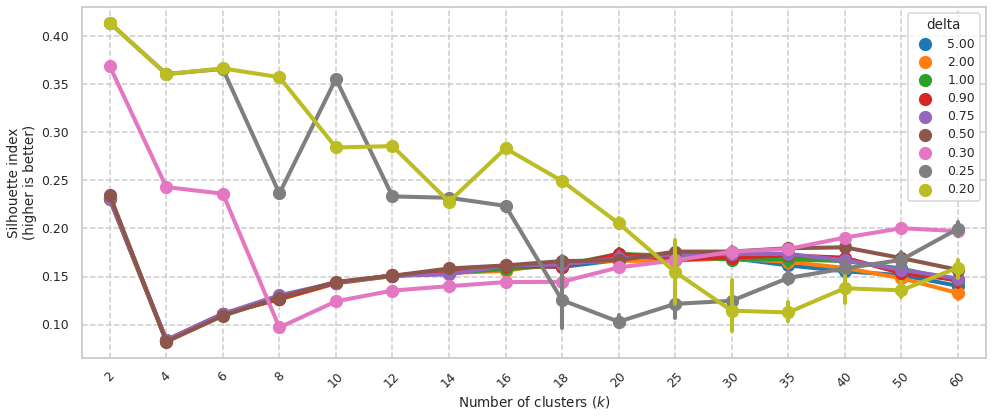

In [65]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score", hue="delta")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

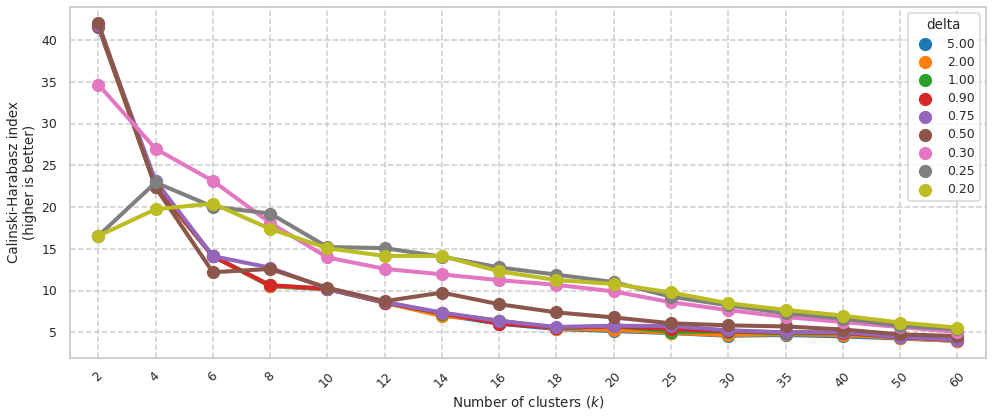

In [66]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="delta")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

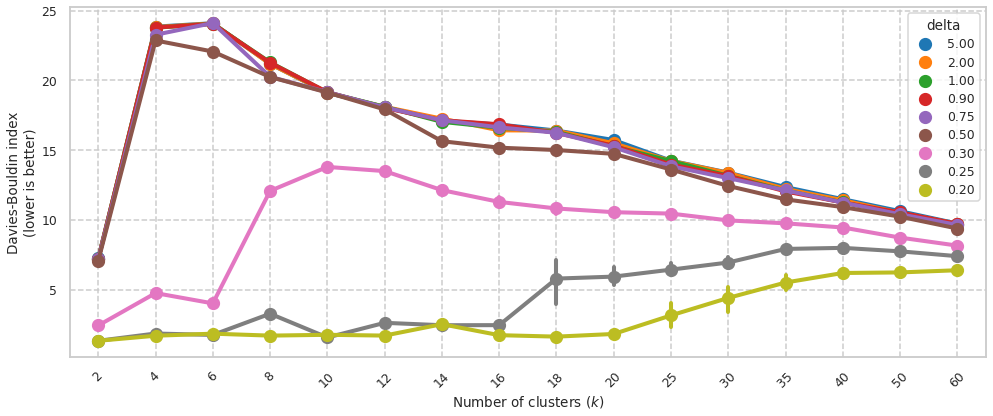

In [67]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score", hue="delta")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [68]:
parts = ensemble.groupby(["delta", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [69]:
parts.shape

(144,)

In [70]:
parts.head()

delta  n_clusters
0.20   2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       8             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       10            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [71]:
parts.iloc[0].shape

(5, 3752)

In [72]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [73]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [74]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [75]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

0.20  2     1.0
5.00  2     1.0
0.30  2     1.0
      4     1.0
      6     1.0
0.25  10    1.0
      8     1.0
      6     1.0
1.00  6     1.0
0.25  4     1.0
      2     1.0
0.20  18    1.0
1.00  2     1.0
0.25  14    1.0
0.20  14    1.0
Name: n_clusters, dtype: float64

In [76]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["delta", "n_clusters"], inplace=True)

In [77]:
parts_ari_df.shape

(144, 10)

In [78]:
_n_total_parts = int(CLUSTERING_OPTIONS["N_REPS_PER_K"])

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [79]:
parts_ari_df.head()

0    1    2    3    4    5    6    7    8    9
delta n_clusters                                                  
0.20  2           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      4           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      6           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      8           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      10          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Stability plot

In [80]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [81]:
parts_ari_df_plot.dtypes

delta          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [82]:
parts_ari_df_plot.head()

,delta,n_clusters,idx,ari
0,0.20,2,0,1.0
1,0.20,2,1,1.0
2,0.20,2,2,1.0
3,0.20,2,3,1.0
4,0.20,2,4,1.0


In [83]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "delta"]).mean()
    display(_df)

idx       ari
n_clusters delta               
2          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  1.000000
           0.75   4.5  1.000000
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  1.000000
           5.00   4.5  1.000000
4          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  0.995016
           0.75   4.5  0.996409
           0.90   4.5  0.995251
           1.00   4.5  0.993463
           2.00   4.5  0.989633
           5.00   4.5  0.993793
6          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  0.999701
           0.75   4.5  0.999543
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  0.997624
           5.00   4.5  0.995774
8          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  0.996005
           0.50   4.5  0.997370
           0.75   4.5  0.985450
           0.90   4.5  0.992212
           1.00   4.5  0.997197
           2.00   4.5  0.999538
           5.00   4.5  0.998535
10         0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  0.996555
           0.50   4.5  0.995465
           0.75   4.5  0.996096
           0.90   4.5  0.994398
           1.00   4.5  0.998752
           2.00   4.5  0.994387
           5.00   4.5  0.999595
12         0.20   4.5  1.000000
           0.25   4.5  0.996986
           0.30   4.5  0.995814
           0.50   4.5  0.966053
           0.75   4.5  0.997645
           0.90   4.5  0.940687
           1.00   4.5  0.998886
           2.00   4.5  0.999034
           5.00   4.5  0.999072
14         0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  0.977275
           0.50   4.5  0.954420
           0.75   4.5  0.951008
           0.90   4.5  0.958302
           1.00   4.5  0.931537
           2.00   4.5  0.924679
           5.00   4.5  0.909378
16         0.20   4.5  0.998646
           0.25   4.5  0.963633
           0.30   4.5  0.755375
           0.50   4.5  0.923160
           0.75   4.5  0.894030
           0.90   4.5  0.920888
           1.00   4.5  0.877274
           2.00   4.5  0.886075
           5.00   4.5  0.910257
18         0.20   4.5  1.000000
           0.25   4.5  0.607794
           0.30   4.5  0.663482
           0.50   4.5  0.910451
           0.75   4.5  0.923336
           0.90   4.5  0.861827
           1.00   4.5  0.895167
           2.00   4.5  0.886727
           5.00   4.5  0.820136
20         0.20   4.5  0.818992
           0.25   4.5  0.377614
           0.30   4.5  0.884252
           0.50   4.5  0.920467
           0.75   4.5  0.902445
           0.90   4.5  0.906791
           1.00   4.5  0.905769
           2.00   4.5  0.882961
           5.00   4.5  0.881380
25         0.20   4.5  0.648555
           0.25   4.5  0.421413
           0.30   4.5  0.897525
           0.50   4.5  0.916856
           0.75   4.5  0.929405
           0.90   4.5  0.914275
           1.00   4.5  0.920034
           2.00   4.5  0.902831
           5.00   4.5  0.897515
30         0.20   4.5  0.318526
           0.25   4.5  0.382700
           0.30   4.5  0.840306
           0.50   4.5  0.900798
           0.75   4.5  0.877014
           0.90   4.5  0.886591
           1.00   4.5  0.870259
           2.00   4.5  0.861140
           5.00   4.5  0.883651
35         0.20   4.5  0.399802
           0.25   4.5  0.514436
           0.30   4.5  0.781016
           0.50   4.5  0.888867
           0.75   4.5  0.855567
           0.90   4.5  0.826902
           1.00   4.5  0.827606
           2.00   4.5  0.830705
           5.00   4.5  0.832460
40         0.20   4.5  0.506255
           0.25   4.5  0.537644
           0.30   4.5  0.923745
           0.50   4.5  0.857288
           0.75   4.5  0.802725
           0.90   4.5  0.836473
           1.00   

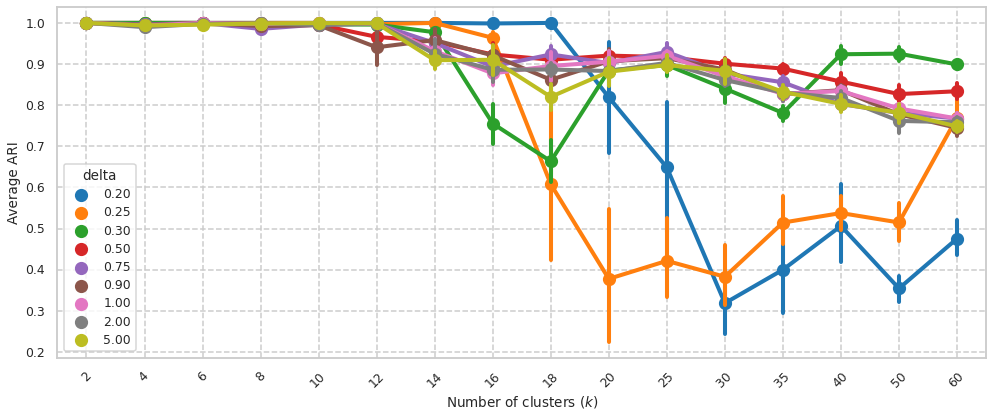

In [84]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="delta")
    ax.set_ylabel("Average ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

**CONCLUSION:** the best values for the `delta` parameter seem to be `0.20`, `0.25`, `0.30`, and `0.50`. `0.50` seems to yield potentially good results when `n_clusters` is high (see `umap` results).